In [12]:
import pickle as pkl 
import tarfile
import xgboost as xgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yaml
sns.set()

## Load the model 

<p><span style="font-weight: 400;">Since Sagemaker XGBoost&rsquo;s implementation supports the open source APIs, we can use the original library to load the model and access it&rsquo;s features.</span></p>

In [2]:
model = pkl.load(open('./artifacts/xgboost-model', 'rb'))

In [17]:
conf = yaml.load(open('./vars.yaml', 'r'), Loader=yaml.SafeLoader)

In [3]:
df_test = pd.read_csv(f's3://{conf["DATA_BUCKET"]}/data/test/test.csv')

In [4]:
cols = ['isfraud', 'amount', 'diff_dest_equal_amount', 'diff_origin_equal_amount', 
 'is_cash_in', 'is_cash_out', 'is_debit', 'is_payment', 'is_transfer',
 'namedest_c', 'nameorig_c', 'newbalancedest', 'newbalanceorig', 
 'oldbalancedest', 'oldbalanceorg']

In [18]:
df_test.columns = cols

In [19]:
model.feature_names = cols[1:]

In [20]:
test_predictions = model.predict(xgb.DMatrix(df_test[cols[1:]]))
df_evaluation = pd.DataFrame()
df_evaluation['label'] = df_test['isfraud']
df_evaluation['prediction'] = test_predictions.reshape(-1)

In [21]:
df_test['prediction'] = df_evaluation['prediction'].values

## Starting with the basic metrics 

In [9]:
# Let's look at some random fraud cases and their scores
df_evaluation[df_evaluation['label'] == 1].sample(5)

,label,prediction
455149,1,0.998012
13856,1,0.990003
1196904,1,0.982197
772736,1,0.997121
604231,1,0.987936


In [10]:
# Looking good! we expect high score for fraud cases, what about non-fraud cases?

In [11]:
df_evaluation[df_evaluation['label'] == 0].sample(5)

,label,prediction
955726,0,0.000040
434911,0,0.000008
6240,0,0.000003
880869,0,0.000015
441930,0,0.000011


In [12]:
# Yep! prertty awesome as well!

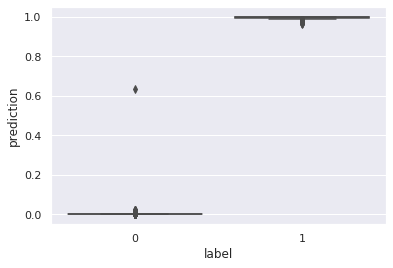

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_evaluation, y='prediction', x='label')
plt.show()

## Calculate model metrics 

In [14]:
from sklearn import  metrics

In [36]:
# Next we can calculate some standard common metrics for these types of problems
print("Recall:", metrics.recall_score(y_true=df_evaluation['label'], y_pred=df_evaluation['predicted_label']))
print("Precision:", metrics.precision_score(y_true=df_evaluation['label'], y_pred=df_evaluation['predicted_label']))
print("F1 Score:", metrics.f1_score(y_true=df_evaluation['label'], y_pred=df_evaluation['predicted_label']))

Recall: 1.0
Precision: 0.998719590268886
F1 Score: 0.9993593850096092


In [15]:
fpr, tpr, _ = metrics.roc_curve(df_evaluation['label'] , df_evaluation['prediction'] , pos_label=1)

In [16]:
roc_auc = metrics.auc(fpr ,tpr)

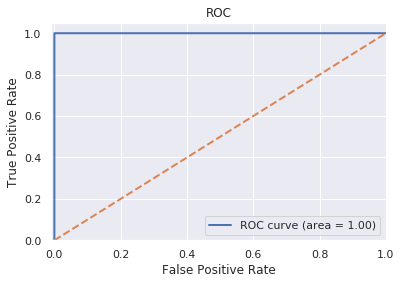

In [17]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [18]:
df_evaluation[(df_evaluation['label']==0)].sort_values(by='prediction', ascending=False).head()

,label,prediction
405960,0,0.633307
1063304,0,0.020918
1251258,0,0.020918
1197393,0,0.020918
1025072,0,0.020918


In [19]:
df_evaluation[(df_evaluation['label']==1)].sort_values(by='prediction', ascending=True).head()

,label,prediction
181889,1,0.965363
992021,1,0.968408
608430,1,0.969166
164718,1,0.969166
992016,1,0.969166


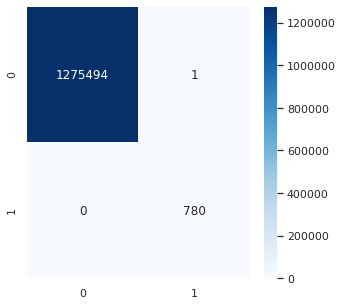

In [20]:
df_evaluation['predicted_label'] = (df_evaluation['prediction'] > 0.5).astype(int)
plt.figure(figsize=(5,5))
sns.heatmap(metrics.confusion_matrix(df_evaluation['label'], df_evaluation['predicted_label']), annot=True, cmap='Blues', fmt='d' )
plt.show()

<p><span style="font-weight: 400;">It looks like only <span style="color: #008000;"><strong>one sample was misclassified</strong> </span>in the test set, which is amazing. With these results the team really doesn&rsquo;t need to reiterate and improve the model!</span></p>

## Better understand the model

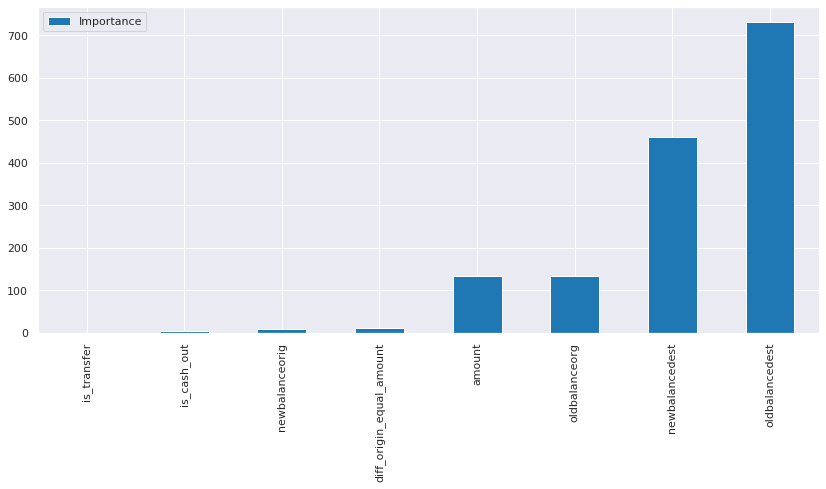

In [21]:
df_importance = pd.DataFrame().from_dict(model.get_fscore(), orient='index')
df_importance.columns = ['Importance']
df_importance.sort_values('Importance').plot(kind='bar', figsize=(14,6), cmap='tab20')
plt.show()

In [22]:
plt.rcParams['figure.figsize'] = 80,50

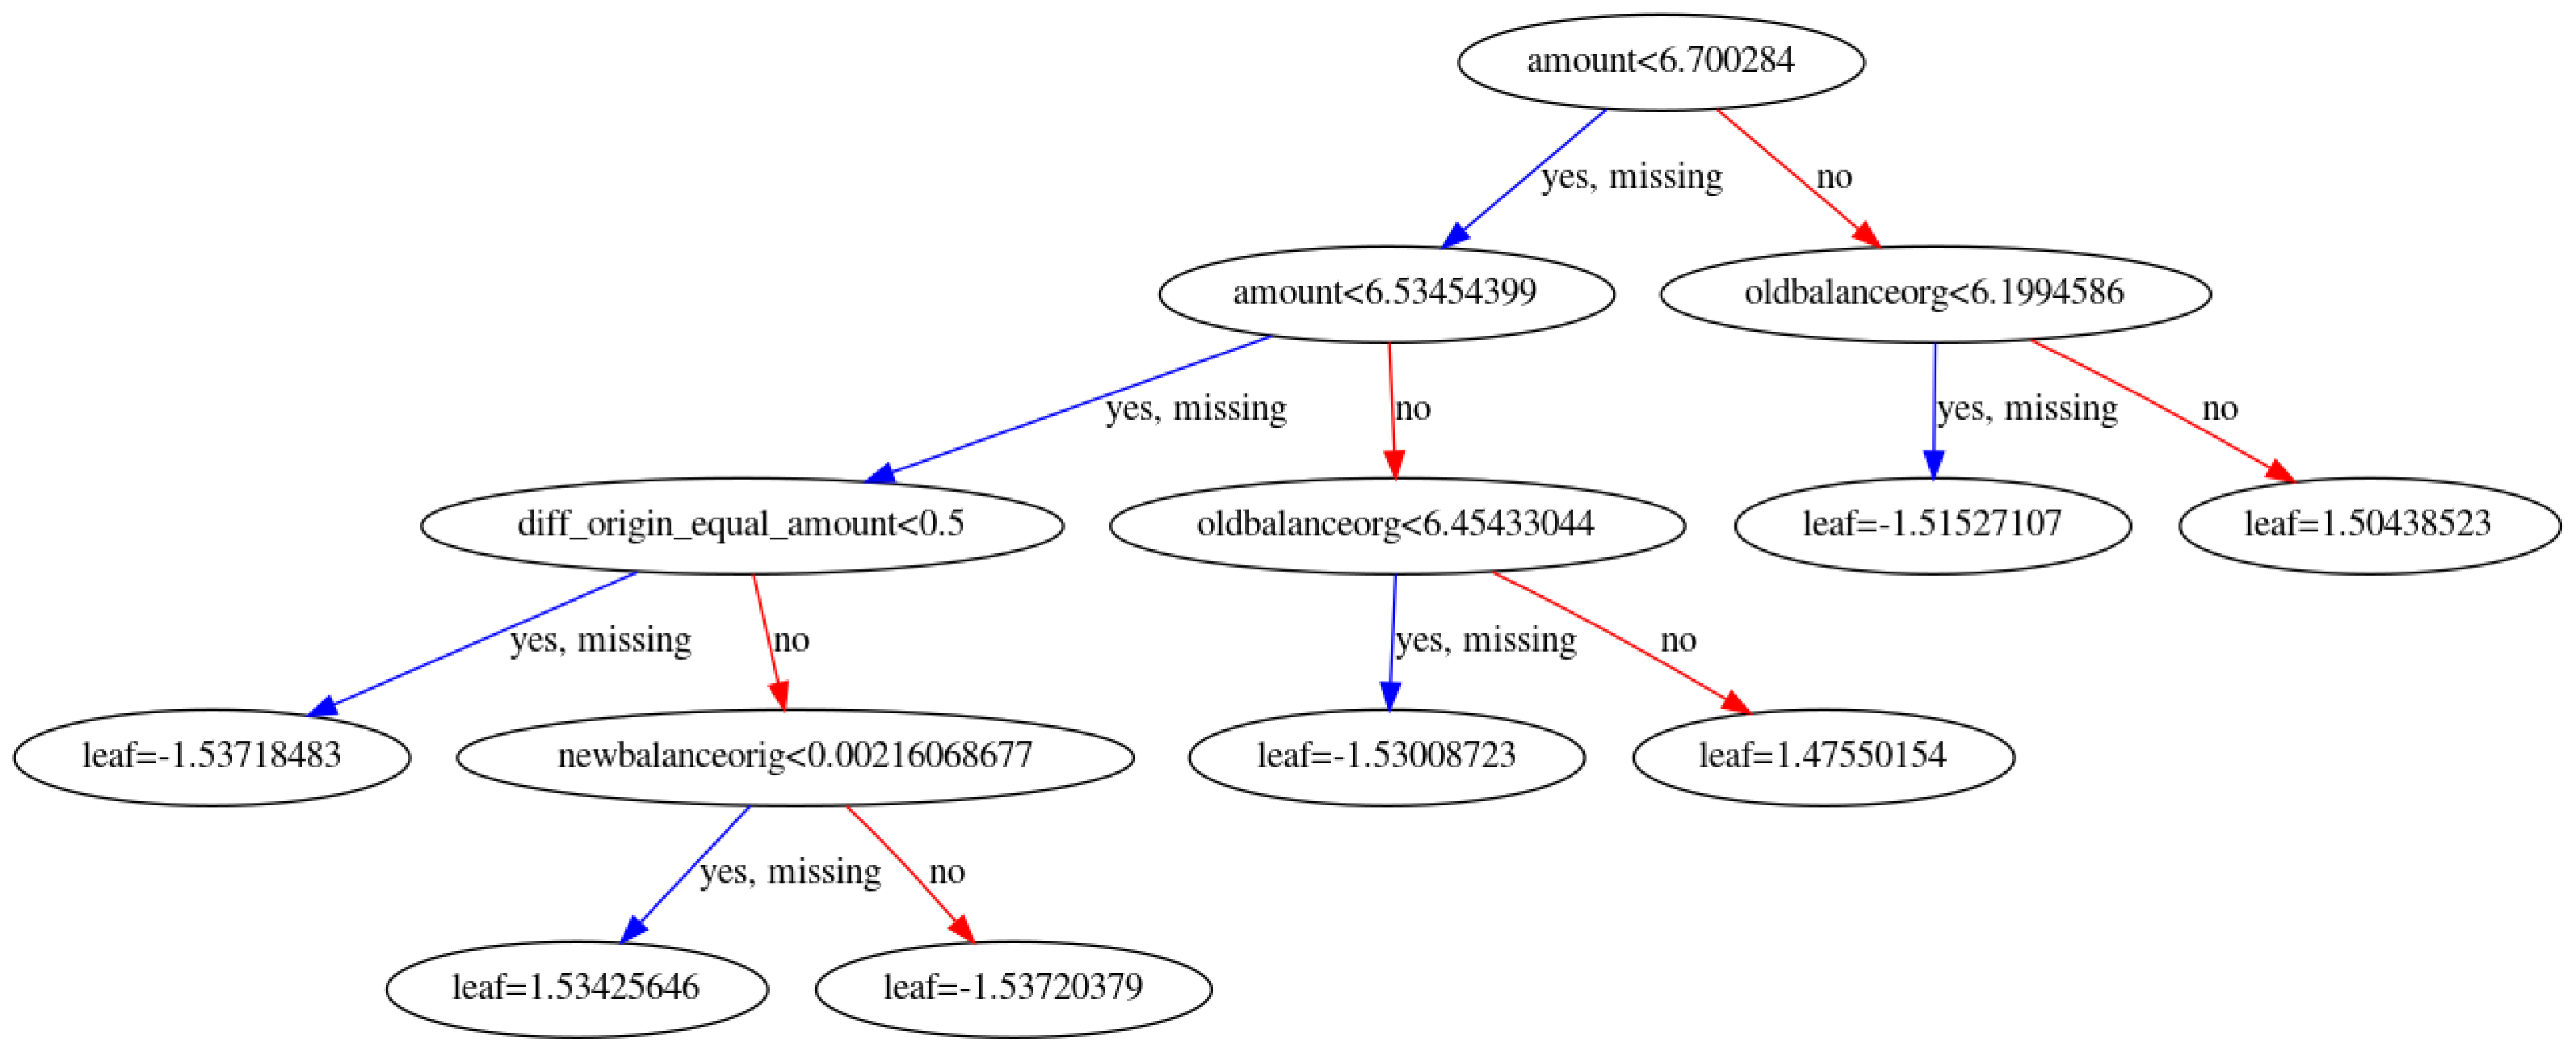

In [23]:
xgb.plot_tree(model)
plt.show()

In [24]:
plt.rcParams['figure.figsize'] = 8,8

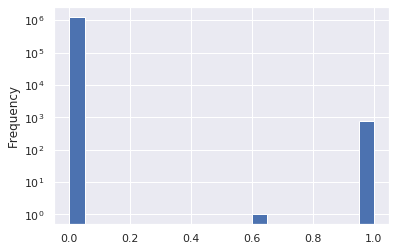

In [25]:
plt.figure(figsize=(6,4))
df_test['prediction'].plot(kind='hist', bins=20,)
plt.yscale('log')

In [26]:
num_features = [ 'amount', 'diff_dest_equal_amount', 'diff_origin_equal_amount',
                'newbalancedest', 'newbalanceorig', 'oldbalancedest', 'oldbalanceorg']

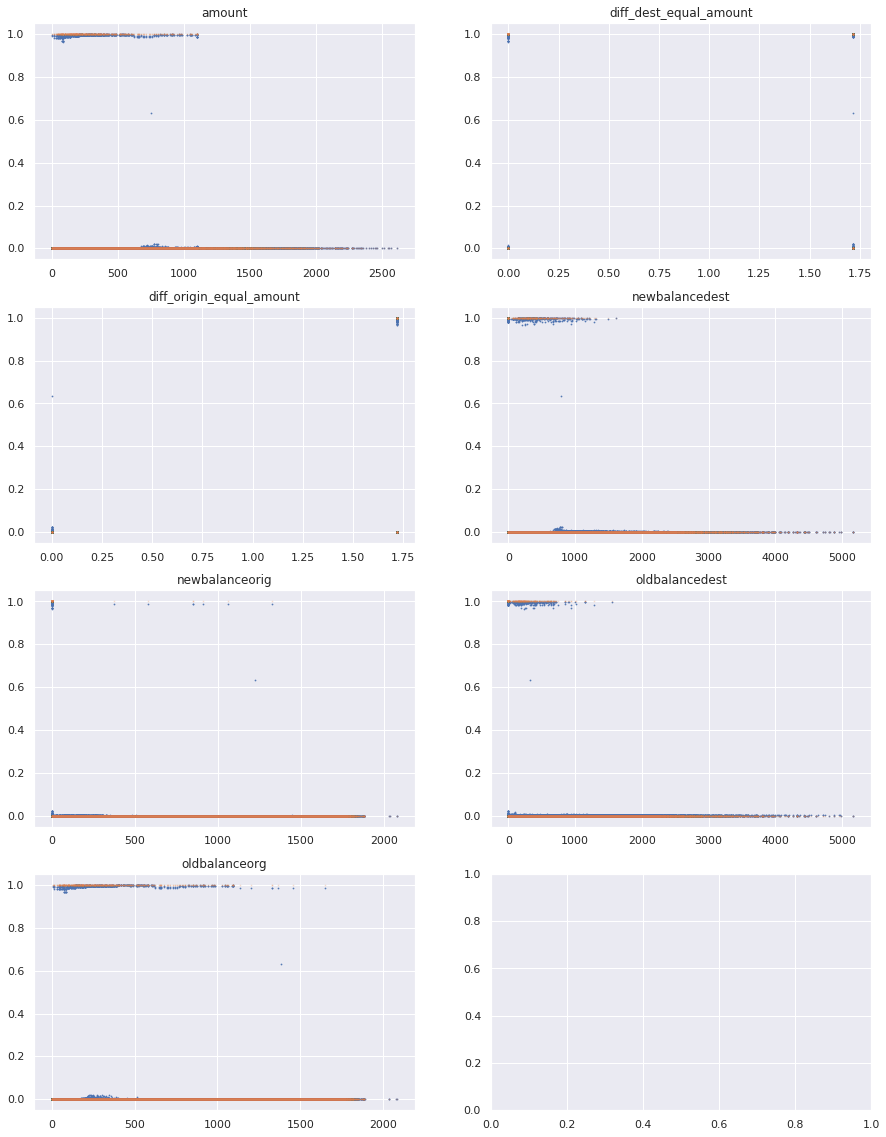

In [28]:
fig, ax = plt.subplots(4, 2, figsize=(15,20))
for plot_i in range(len(num_features)):
    row = int(plot_i / 2)
    col = plot_i % 2
    ax[row, col].scatter(x=np.expm1(df_test[num_features[plot_i]]),
                         y=df_test['prediction'], s=0.6, alpha=0.9)
    ax[row, col].scatter(x=np.expm1(df_test[num_features[plot_i]]),
                         y=df_test['isfraud'], s=0.6, alpha=0.2)
    ax[row, col].set_title(num_features[plot_i])
plt.show()